# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.57KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [3]:
print(1)

1


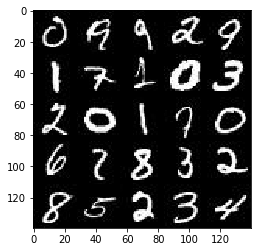

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

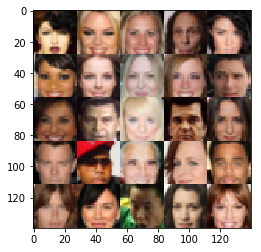

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'input_img')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse = reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
#         relu1 = tf.nn.relu(x1)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
#         relu2 = tf.nn.relu(x2)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
#         relu3 = tf.nn.relu(bn3)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
#         x1 = tf.nn.relu(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.nn.relu(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
      
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    samples, losses = [], []
    steps = 0

    _, input_width, input_height, out_channel_dim = data_shape
    
    print_every = 10
    show_every = 100
    n_images = 25
    
    # Sample random noise for G

    input_real, input_z, input_lr = model_inputs(input_width, input_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
                
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for e in range(epoch_count):
            for batch_real in get_batches(batch_size):
                batch_real *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) 
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_real, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_real, input_z: batch_z,  input_lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real:batch_real, input_z:batch_z, input_lr :learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_lr: learning_rate})

                    print("Epoch {}/{}...".format(e+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4619... Generator Loss: 5.8519
Epoch 1/2... Discriminator Loss: 2.2288... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.6246
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.6831
Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 2.2006
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.6850... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 2.4627
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.7262


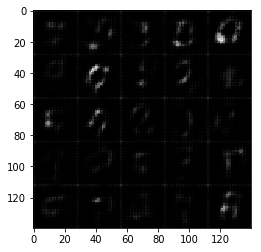

Epoch 1/2... Discriminator Loss: 1.6716... Generator Loss: 0.4187
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 1.4999
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 1.7220
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.2684
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.1356


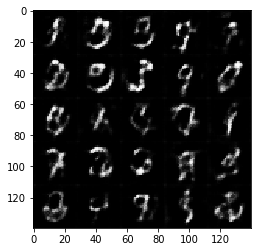

Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 1.9636
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 1.5189
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 1.4054
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 1.3776
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.0545


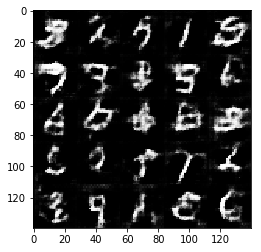

Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.6357
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.9187
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 1.8688
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 0.3695


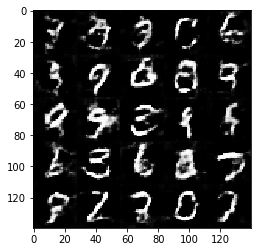

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.7951... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.7045
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 1.2028
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 1.8390
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.0820


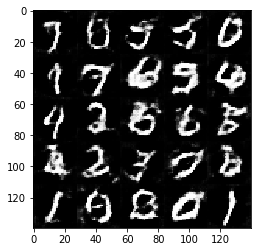

Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.6600
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 1.6062
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.5511
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.6344
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 2.4011
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 0.9973


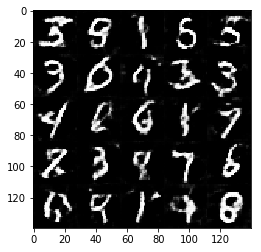

Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.5728
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.1852
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.7178
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.6015


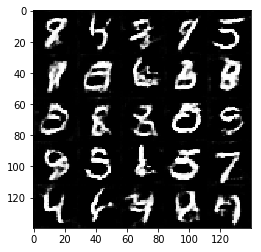

Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 2.1033
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.4486
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 1.2601
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.6907
Epoch 1/2... Discriminator Loss: 2.7114... Generator Loss: 0.1642
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.4749


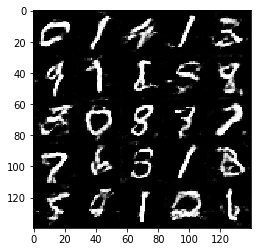

Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.3942
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 2.4855
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.1969
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 4.2530... Generator Loss: 5.1881
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.8418


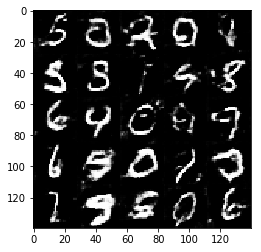

Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 1.0826... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 1.0535
Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 1.3117


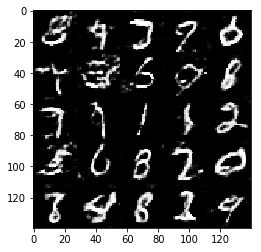

Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 2.2222
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.3321


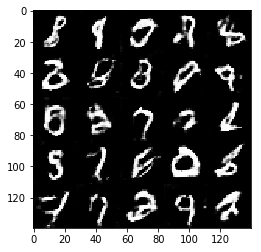

Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 2.4840
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.5680
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.1822
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 1.5598... Generator Loss: 0.5008
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 2.8724
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.6168


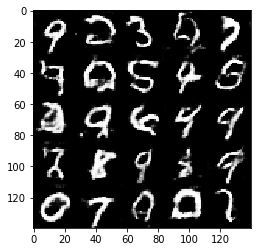

Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 1.9584
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.1764
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.6102
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 2.8874


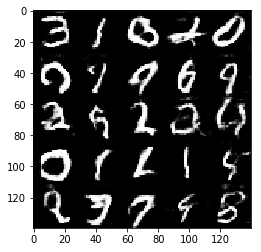

Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.3684
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.4656
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.3484
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 1.7691


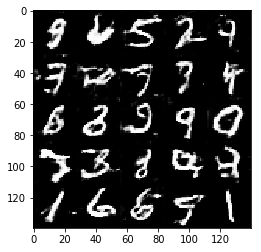

Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1715
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 1.5848
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 1.8903
Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.3452
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.6416
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.9624


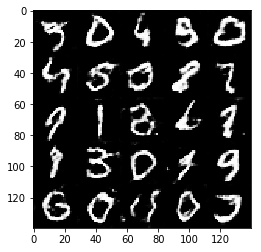

Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.8997... Generator Loss: 3.5156
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 1.7636
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.2087


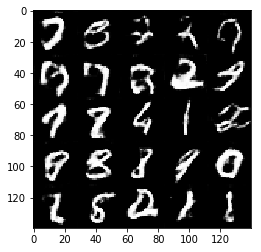

Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.4212
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 1.7415
Epoch 2/2... Discriminator Loss: 0.6283... Generator Loss: 2.0396
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 3.0171
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.1547
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.2103


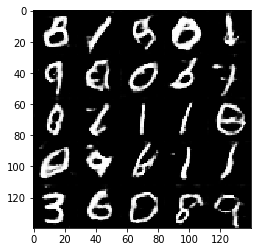

Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.5066
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 2.8447
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.6590
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 2.4179
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.2291
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.2894


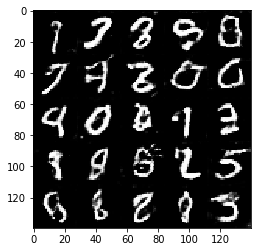

Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 1.5550
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 2.4993
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 2.5863
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 2.4421


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7190
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.3537
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.6941
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.7343
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 2.1487
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.9057
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 1.3432
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 1.4702


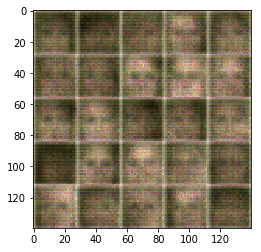

Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 1.8386
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.4762
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.6409
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.5950
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.0422


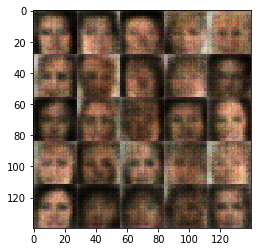

Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.8766... Generator Loss: 1.8148
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 1.1641
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 1.1598


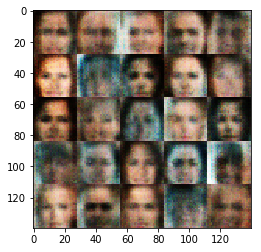

Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.8238
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.7214
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.5985
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.4420
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.4416


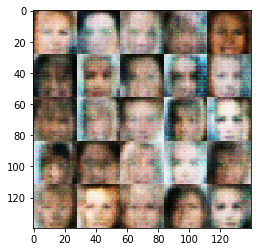

Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.3257
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 1.1985
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.0889
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.7678


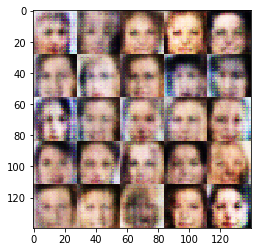

Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.6772
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.0476
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.4871
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.6767
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.5911
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 0.6721
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 1.2498


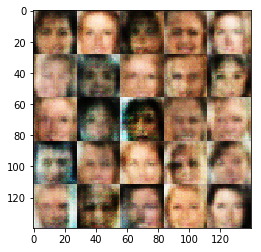

Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 1.9042
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 1.0915
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.8791


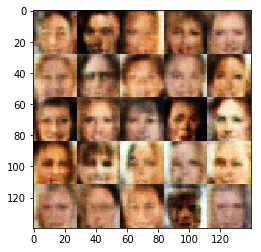

Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 1.2673
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 1.1033
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.1855


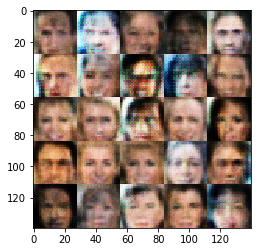

Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.0714
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.7852


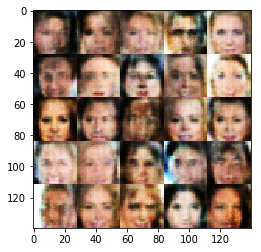

Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.2500


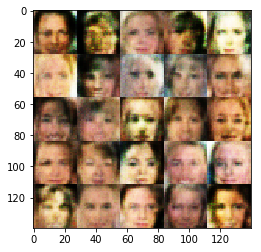

Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 1.6694
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.7402


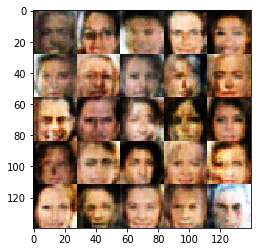

Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.2910
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 1.1863
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.9834


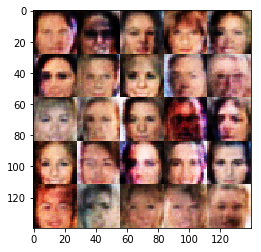

Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.6313
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.5706
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.6422
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.2119
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.4941


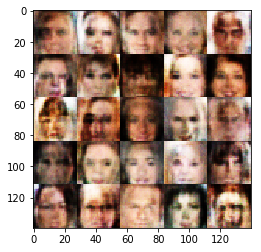

Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 0.8557... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.3749
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 1.5835
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.4679


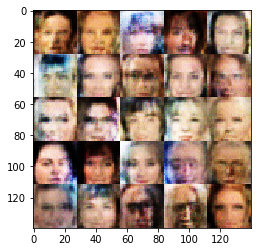

Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.7564
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 2.2213
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 2.1302


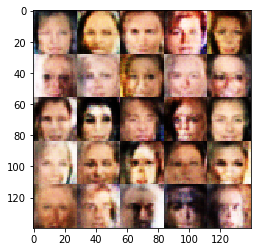

Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 2.3408
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.7413
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.6728


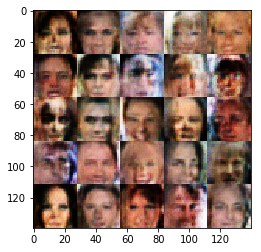

Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.9444
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.3810
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 1.2207


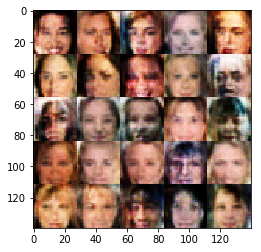

Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 2.2073
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.5922
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 2.0962
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.5773
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6058


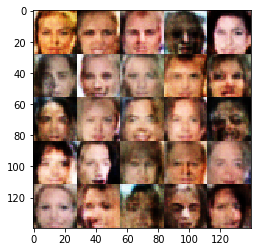

Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 3.0220
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 1.7151
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 2.1069
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 1.8570
Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 2.4825
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 3.0318
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 3.1904


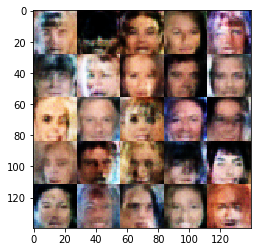

Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 4.2834
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 5.2835
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 2.5219
Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.5770
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 4.5882
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 2.8093
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 2.0254
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 2.2235
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 2.2600
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 2.2550


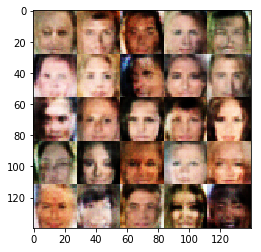

Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.9524
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 4.0343
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 2.3911
Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 2.1395
Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 5.5406
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 5.8146
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 0.9939
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.4464


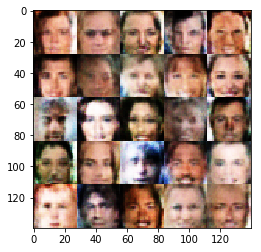

Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 3.7210
Epoch 1/2... Discriminator Loss: 1.9206... Generator Loss: 0.2687
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 6.2915
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 6.4933
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.4156
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 7.3825
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 3.2565
Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 1.9296


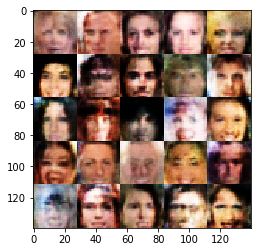

Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 2.0065
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 5.2079
Epoch 1/2... Discriminator Loss: 0.3791... Generator Loss: 6.1271
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 2.4289
Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 4.0000
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 0.4481... Generator Loss: 3.1125
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.0433


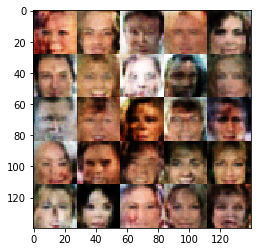

Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 4.3318
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 7.4572
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 8.0631
Epoch 1/2... Discriminator Loss: 0.3774... Generator Loss: 4.1062
Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 3.0591
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.6438
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 3.7726
Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.8600


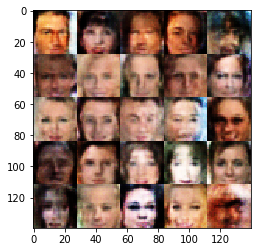

Epoch 1/2... Discriminator Loss: 0.3720... Generator Loss: 3.9841
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 5.3730
Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 3.8896
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 2.1894
Epoch 1/2... Discriminator Loss: 0.3581... Generator Loss: 4.3234
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 5.9557
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.6705
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 3.2956


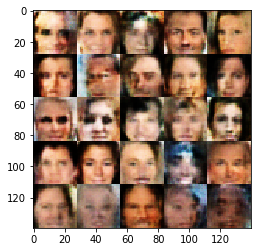

Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 5.1560
Epoch 1/2... Discriminator Loss: 0.4714... Generator Loss: 8.3337
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 3.4144
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 3.1982
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.1349
Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 2.5987
Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 3.0113
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 9.0669


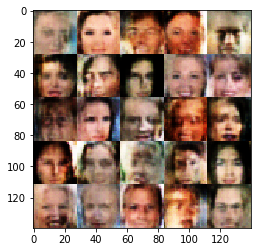

Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.5508
Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 4.1532
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 5.2905
Epoch 1/2... Discriminator Loss: 0.5118... Generator Loss: 8.6668
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 2.4063
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.4249
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 4.2900
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 2.7730
Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 3.9994


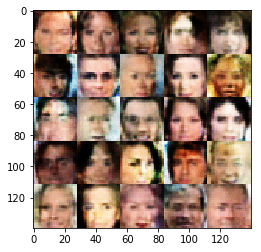

Epoch 1/2... Discriminator Loss: 0.4830... Generator Loss: 2.1772
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 4.9626
Epoch 1/2... Discriminator Loss: 0.3777... Generator Loss: 3.4264
Epoch 1/2... Discriminator Loss: 0.3585... Generator Loss: 5.6926
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 1.9352
Epoch 1/2... Discriminator Loss: 0.3605... Generator Loss: 4.6612
Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 5.9479
Epoch 1/2... Discriminator Loss: 0.4738... Generator Loss: 2.3637
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 3.7866
Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 3.0750


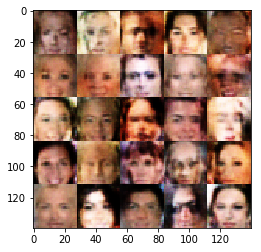

Epoch 1/2... Discriminator Loss: 0.4567... Generator Loss: 3.2944
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 3.2002
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 7.0924
Epoch 1/2... Discriminator Loss: 0.5186... Generator Loss: 1.9740
Epoch 1/2... Discriminator Loss: 0.3707... Generator Loss: 4.2880
Epoch 1/2... Discriminator Loss: 0.3609... Generator Loss: 4.3978
Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 4.2716
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.2237
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 3.3599


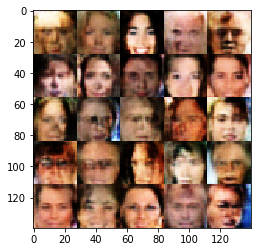

Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 6.3187
Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 2.2375
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 4.6333
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 5.3436
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 6.1242
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 3.0395
Epoch 1/2... Discriminator Loss: 0.5640... Generator Loss: 1.7481
Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 3.7593
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 6.3860
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 6.5760


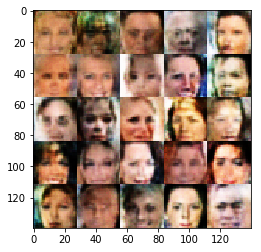

Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 7.2282
Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 2.7562
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 5.9528
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 2.6306
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 5.1204
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.5016
Epoch 1/2... Discriminator Loss: 0.4035... Generator Loss: 3.0277
Epoch 1/2... Discriminator Loss: 0.6025... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 7.0323


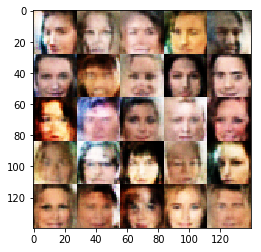

Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.1204
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 2.2028
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.6520
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 2.1793
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 5.7199
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 8.2808
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 2.7444
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.7327


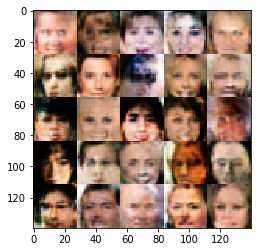

Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 2.8886
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 2.1495
Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 3.7759
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 5.6567
Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 8.5687
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 6.6196
Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 7.8877
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 1.4256


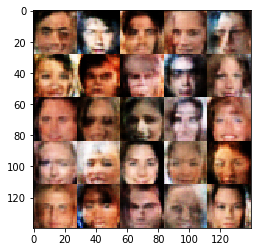

Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 4.1709
Epoch 2/2... Discriminator Loss: 0.4959... Generator Loss: 2.0464
Epoch 2/2... Discriminator Loss: 0.3446... Generator Loss: 6.3528
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 6.1064
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 3.2421
Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 7.5499
Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 10.2904


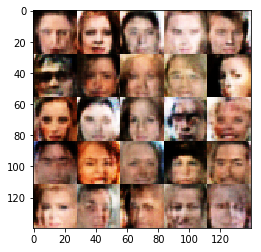

Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 2.8128
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 5.0411
Epoch 2/2... Discriminator Loss: 0.6347... Generator Loss: 1.6475
Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 4.6048
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 2.3699
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 6.4177
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 3.3640
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.2422


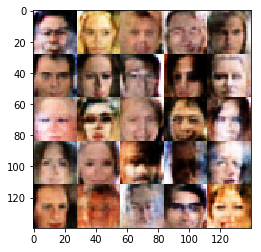

Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 6.6241
Epoch 2/2... Discriminator Loss: 0.3646... Generator Loss: 5.3451
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 4.0167
Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 5.7184
Epoch 2/2... Discriminator Loss: 0.3453... Generator Loss: 5.1857
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 8.4936
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 3.9916
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 5.0337
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.0571
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 4.4163


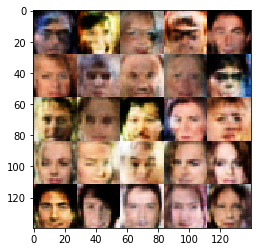

Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 7.9164
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 6.0195
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 7.3862
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 5.5654
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.2440
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 5.4912
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 2.7459


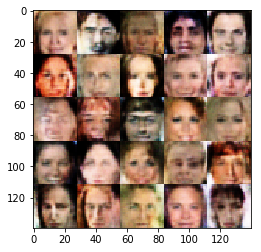

Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 6.6230
Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 4.3389
Epoch 2/2... Discriminator Loss: 0.3460... Generator Loss: 5.1568
Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 2.9543
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.7503
Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 6.4905
Epoch 2/2... Discriminator Loss: 0.3510... Generator Loss: 6.5028
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.2604
Epoch 2/2... Discriminator Loss: 0.3523... Generator Loss: 6.2726
Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 5.5168


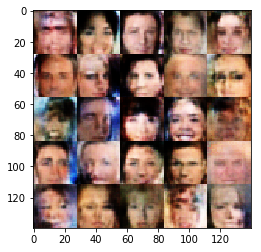

Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 3.6885
Epoch 2/2... Discriminator Loss: 0.4155... Generator Loss: 2.7255
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.4276... Generator Loss: 2.7133
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 4.7507
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 4.7187
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 3.6713
Epoch 2/2... Discriminator Loss: 0.3482... Generator Loss: 5.2522


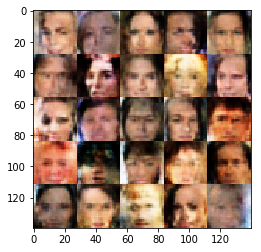

Epoch 2/2... Discriminator Loss: 0.3457... Generator Loss: 6.8170
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 9.2880
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 2.3259
Epoch 2/2... Discriminator Loss: 0.3369... Generator Loss: 6.9485
Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 5.6751
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 5.0035
Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 11.0029
Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 2.3565
Epoch 2/2... Discriminator Loss: 0.3583... Generator Loss: 6.7143
Epoch 2/2... Discriminator Loss: 0.4032... Generator Loss: 3.0033


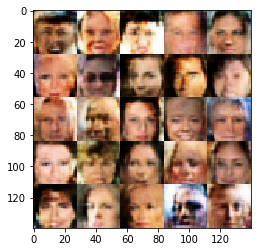

Epoch 2/2... Discriminator Loss: 0.3394... Generator Loss: 5.1043
Epoch 2/2... Discriminator Loss: 0.3877... Generator Loss: 3.2192
Epoch 2/2... Discriminator Loss: 0.5396... Generator Loss: 1.8896
Epoch 2/2... Discriminator Loss: 0.3936... Generator Loss: 3.0577
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 3.6656
Epoch 2/2... Discriminator Loss: 2.0296... Generator Loss: 0.2706
Epoch 2/2... Discriminator Loss: 0.3457... Generator Loss: 5.3205
Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 4.3097
Epoch 2/2... Discriminator Loss: 0.4852... Generator Loss: 2.1213
Epoch 2/2... Discriminator Loss: 0.3484... Generator Loss: 5.2379


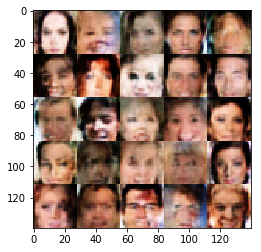

Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 8.1354
Epoch 2/2... Discriminator Loss: 0.3474... Generator Loss: 5.0901
Epoch 2/2... Discriminator Loss: 0.3505... Generator Loss: 4.3627
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 7.6093
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 9.2889
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 4.4197
Epoch 2/2... Discriminator Loss: 0.3563... Generator Loss: 4.1949
Epoch 2/2... Discriminator Loss: 0.3800... Generator Loss: 6.8368
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 3.7459
Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 2.8707


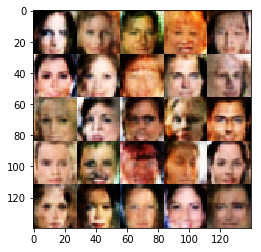

Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 5.9133
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 3.4637
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 5.1817
Epoch 2/2... Discriminator Loss: 0.3579... Generator Loss: 8.3430
Epoch 2/2... Discriminator Loss: 0.3644... Generator Loss: 4.0417
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 4.2474
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 9.0866
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 7.4913
Epoch 2/2... Discriminator Loss: 0.3474... Generator Loss: 4.7314
Epoch 2/2... Discriminator Loss: 0.3370... Generator Loss: 6.7678


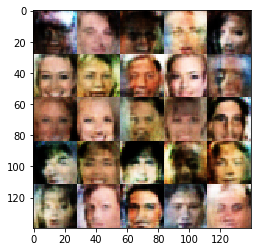

Epoch 2/2... Discriminator Loss: 0.4769... Generator Loss: 2.1410
Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 5.9547
Epoch 2/2... Discriminator Loss: 0.3437... Generator Loss: 4.8470
Epoch 2/2... Discriminator Loss: 0.3364... Generator Loss: 6.1693
Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 2.6185
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 4.6154
Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 8.4388
Epoch 2/2... Discriminator Loss: 0.5521... Generator Loss: 9.8783
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 5.7147
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 8.7416


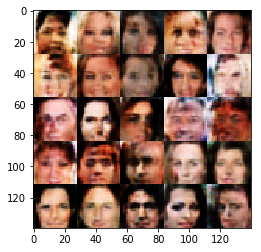

Epoch 2/2... Discriminator Loss: 0.3483... Generator Loss: 5.0761
Epoch 2/2... Discriminator Loss: 0.4215... Generator Loss: 2.8287
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 4.1827
Epoch 2/2... Discriminator Loss: 0.5544... Generator Loss: 1.8091
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 6.7967
Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 5.4467
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 2.9602
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.4227
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.5778


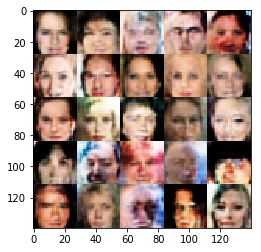

Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 6.6331
Epoch 2/2... Discriminator Loss: 0.5375... Generator Loss: 1.8377
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 3.7554
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 5.7640
Epoch 2/2... Discriminator Loss: 0.3498... Generator Loss: 6.9660
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 4.1582
Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 7.1264
Epoch 2/2... Discriminator Loss: 0.3496... Generator Loss: 6.4208
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 6.1880
Epoch 2/2... Discriminator Loss: 0.3443... Generator Loss: 7.4167


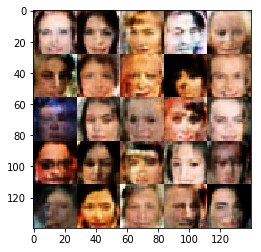

Epoch 2/2... Discriminator Loss: 0.3730... Generator Loss: 6.4140
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.3438... Generator Loss: 9.4985
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 10.9553
Epoch 2/2... Discriminator Loss: 0.3441... Generator Loss: 5.7106
Epoch 2/2... Discriminator Loss: 0.3915... Generator Loss: 10.3595
Epoch 2/2... Discriminator Loss: 0.3507... Generator Loss: 4.7019
Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 2.6526
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 2.0235
Epoch 2/2... Discriminator Loss: 0.3369... Generator Loss: 7.8554


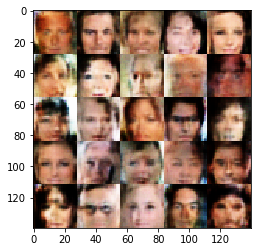

Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 5.2996
Epoch 2/2... Discriminator Loss: 0.5895... Generator Loss: 1.5824
Epoch 2/2... Discriminator Loss: 0.3543... Generator Loss: 6.3100
Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 8.4181
Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.5940
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 5.4670
Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 9.6835
Epoch 2/2... Discriminator Loss: 0.4487... Generator Loss: 2.3883
Epoch 2/2... Discriminator Loss: 0.3379... Generator Loss: 6.1224
Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 7.1628


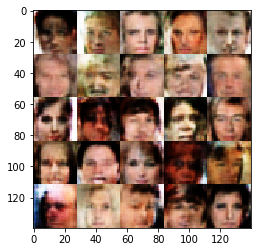

Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 6.4491
Epoch 2/2... Discriminator Loss: 0.3852... Generator Loss: 3.1550
Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 3.6922
Epoch 2/2... Discriminator Loss: 5.6221... Generator Loss: 6.9729
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 0.3480... Generator Loss: 8.6882
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 7.1714
Epoch 2/2... Discriminator Loss: 0.3511... Generator Loss: 6.2040
Epoch 2/2... Discriminator Loss: 0.3612... Generator Loss: 4.2611
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 6.5797


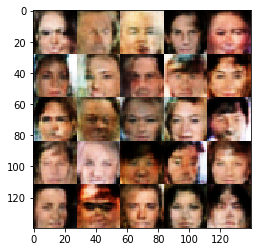

Epoch 2/2... Discriminator Loss: 0.3690... Generator Loss: 3.7629
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 4.1570
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.9027
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 7.5391
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 7.6009
Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 0.3559... Generator Loss: 4.1643
Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 6.0307
Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 6.8038
Epoch 2/2... Discriminator Loss: 0.3622... Generator Loss: 3.8139


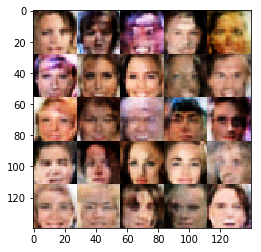

Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 5.6963
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 5.3088
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 4.4256
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 4.9927
Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 4.6505
Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 7.8381
Epoch 2/2... Discriminator Loss: 0.4196... Generator Loss: 2.6810
Epoch 2/2... Discriminator Loss: 0.3342... Generator Loss: 9.2951
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 7.5209
Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 4.6679


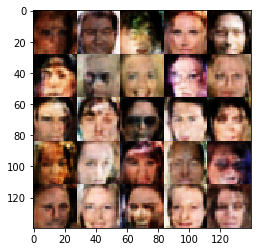

Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 6.3470
Epoch 2/2... Discriminator Loss: 0.4527... Generator Loss: 2.3988
Epoch 2/2... Discriminator Loss: 0.3446... Generator Loss: 5.2259
Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 5.3999
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 0.4886... Generator Loss: 7.4524
Epoch 2/2... Discriminator Loss: 0.3411... Generator Loss: 5.5155
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 6.0114
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 7.9049
Epoch 2/2... Discriminator Loss: 0.3532... Generator Loss: 4.7888


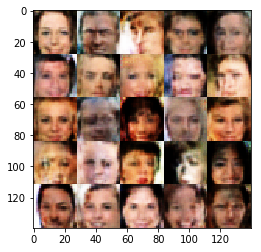

Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 8.6187
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 8.7908
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.4873
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 2.6052
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 4.9069
Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 5.1292
Epoch 2/2... Discriminator Loss: 0.3444... Generator Loss: 5.0465
Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.4584
Epoch 2/2... Discriminator Loss: 0.5155... Generator Loss: 1.9468
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 1.9588


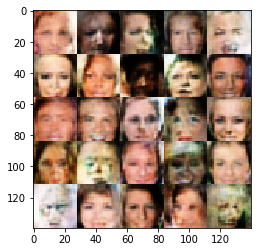

Epoch 2/2... Discriminator Loss: 0.3432... Generator Loss: 6.0766
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 4.6788
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 2.7372
Epoch 2/2... Discriminator Loss: 0.3496... Generator Loss: 5.0575
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 5.3508
Epoch 2/2... Discriminator Loss: 0.3717... Generator Loss: 5.8728
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 3.3047
Epoch 2/2... Discriminator Loss: 0.4421... Generator Loss: 6.9590
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 6.0354
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 6.0572


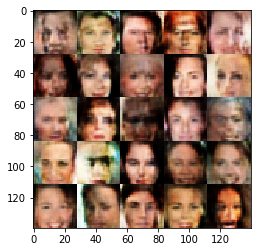

Epoch 2/2... Discriminator Loss: 1.8822... Generator Loss: 0.2838
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 4.1009
Epoch 2/2... Discriminator Loss: 0.3469... Generator Loss: 5.9087
Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 4.7786
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 7.5050
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 3.9455
Epoch 2/2... Discriminator Loss: 0.3517... Generator Loss: 4.0499
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 5.3675
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 5.1604


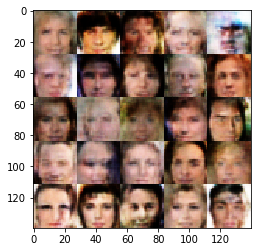

Epoch 2/2... Discriminator Loss: 0.3416... Generator Loss: 5.4343
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 2.9091
Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 6.6625
Epoch 2/2... Discriminator Loss: 0.3379... Generator Loss: 5.5150
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.6703
Epoch 2/2... Discriminator Loss: 0.4789... Generator Loss: 2.2639
Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 3.0383
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 8.8703
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 1.8596


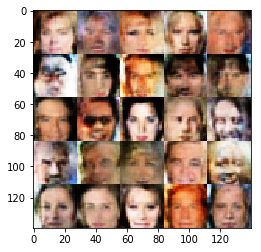

Epoch 2/2... Discriminator Loss: 0.3556... Generator Loss: 4.2845
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 5.5237
Epoch 2/2... Discriminator Loss: 0.5059... Generator Loss: 2.0398
Epoch 2/2... Discriminator Loss: 0.7466... Generator Loss: 1.2183
Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 6.2286
Epoch 2/2... Discriminator Loss: 0.4862... Generator Loss: 2.1263
Epoch 2/2... Discriminator Loss: 0.3978... Generator Loss: 3.4005
Epoch 2/2... Discriminator Loss: 0.4549... Generator Loss: 3.8605
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 3.4730
Epoch 2/2... Discriminator Loss: 0.4264... Generator Loss: 6.5284


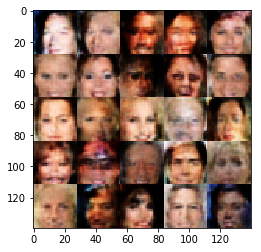

Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 7.2839
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 5.5418
Epoch 2/2... Discriminator Loss: 0.3515... Generator Loss: 4.6262
Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 5.4112
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 4.5555
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 6.9434
Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 7.7294
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 6.6980
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 2.3617
Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 4.1722


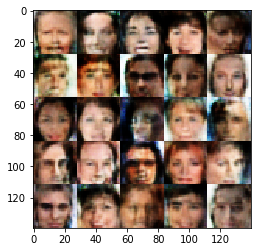

Epoch 2/2... Discriminator Loss: 0.3714... Generator Loss: 7.1590
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 5.5357
Epoch 2/2... Discriminator Loss: 0.4487... Generator Loss: 2.4291
Epoch 2/2... Discriminator Loss: 0.3382... Generator Loss: 6.5532
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 2.7603
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 7.2381
Epoch 2/2... Discriminator Loss: 0.3362... Generator Loss: 6.5542
Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 6.2996
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 3.4261
Epoch 2/2... Discriminator Loss: 0.5049... Generator Loss: 9.0872


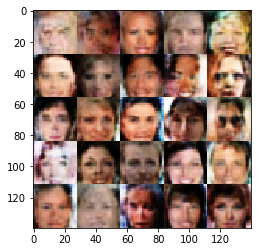

Epoch 2/2... Discriminator Loss: 0.3584... Generator Loss: 6.8963
Epoch 2/2... Discriminator Loss: 0.3754... Generator Loss: 4.9386
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 3.5113
Epoch 2/2... Discriminator Loss: 0.3530... Generator Loss: 4.1809
Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 7.1280
Epoch 2/2... Discriminator Loss: 0.3414... Generator Loss: 5.3501
Epoch 2/2... Discriminator Loss: 0.4408... Generator Loss: 2.5062
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 9.5078
Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 10.3095
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 1.9489


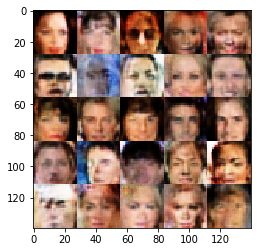

Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 2.6661
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 10.8790
Epoch 2/2... Discriminator Loss: 0.3746... Generator Loss: 3.3656
Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 3.1849
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 4.7014
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 9.4718
Epoch 2/2... Discriminator Loss: 1.9218... Generator Loss: 7.3072
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 4.9824


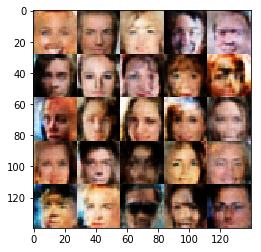

Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 3.8321
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 1.9531
Epoch 2/2... Discriminator Loss: 0.3514... Generator Loss: 4.3691
Epoch 2/2... Discriminator Loss: 0.4791... Generator Loss: 8.4463
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 3.4937
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.7144
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 6.6577
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 3.7056


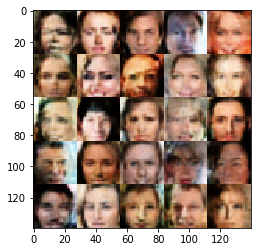

Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 6.0883
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 4.7917
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 1.1757
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 6.2647
Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 7.5721
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 5.5334
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 6.1194
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 4.0678
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 2.0936


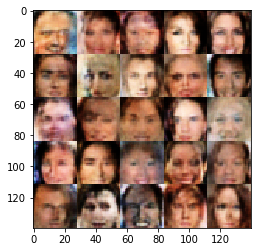

Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 2.9547
Epoch 2/2... Discriminator Loss: 0.3538... Generator Loss: 6.3390
Epoch 2/2... Discriminator Loss: 1.7779... Generator Loss: 0.3283


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [20]:
print('the end')

the end
